In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import csv
import time

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)




1 Physical GPUs, 1 Logical GPUs


In [17]:
batch_size = 32
convOptions = {
    "kernel_size": 3,
    "strides": 1,
    "padding": 'SAME', 
    "activation": tf.nn.relu
}
maxPoolOptions = {
    "pool_size": 2,
    "strides": 2,
    "padding": 'SAME'
}


LInputTarget = tf.keras.Input(dtype = tf.float32, shape = [256, 256, 3], name = 'Target')
layersEncoder = [LInputTarget]
transcoderInputs = []
with tf.name_scope("Encoder"):
    filtersNumber=[64, 64, None, 128, 128, None, 256, 256, None, 512, 512, None, 512, 512, None]
    for fn in filtersNumber:
        if fn is None:
            layersEncoder.append(tf.keras.layers.MaxPool2D(**maxPoolOptions)(layersEncoder[-1]))
            transcoderInputs.append(layersEncoder[-1])
        else:
            layersEncoder.append(tf.keras.layers.Conv2D(filters = fn, **convOptions)(layersEncoder[-1]))
    encoderOutput = layersEncoder[-1]
#     Lconv1_1 = tf.keras.layers.Conv2D(filters = 64, **convOptions)(LInputTarget) 
#     Lconv1_2 = tf.keras.layers.Conv2D(filters = 64, **convOptions)(Lconv1_1) 
#     Lpool1 = tf.keras.layers.MaxPool2D(**maxPoolOptions)(Lconv1_2)

#     Lconv2_1 = tf.keras.layers.Conv2D(filters = 128, **convOptions)(Lpool1) 
#     Lconv2_2 = tf.keras.layers.Conv2D(filters = 128, **convOptions)(Lconv2_1) 
#     Lpool2 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(Lconv2_2)

#     Lconv3_1 = tf.keras.layers.Conv2D(filters = 256, **convOptions)(Lpool2) 
#     Lconv3_2 = tf.keras.layers.Conv2D(filters = 256,**convOptions)(Lconv3_1) 
#     Lpool3 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(Lconv3_2)

#     Lconv4_1 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(Lpool3) 
#     Lconv4_2 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(Lconv4_1) 
#     Lpool4 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(Lconv4_2)

#     Lconv5_1 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(Lpool4) 
#     Lconv5_2 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(Lconv5_1) 
#     Lpool5 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(Lconv5_2)
    
    modelEncoder = tf.keras.Model(
        inputs=LInputTarget, 
        outputs=encoderOutput,
        name="Encoder model"
    )

In [18]:
modelEncoder.summary()

Model: "Encoder model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Target (InputLayer)          [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 128)     

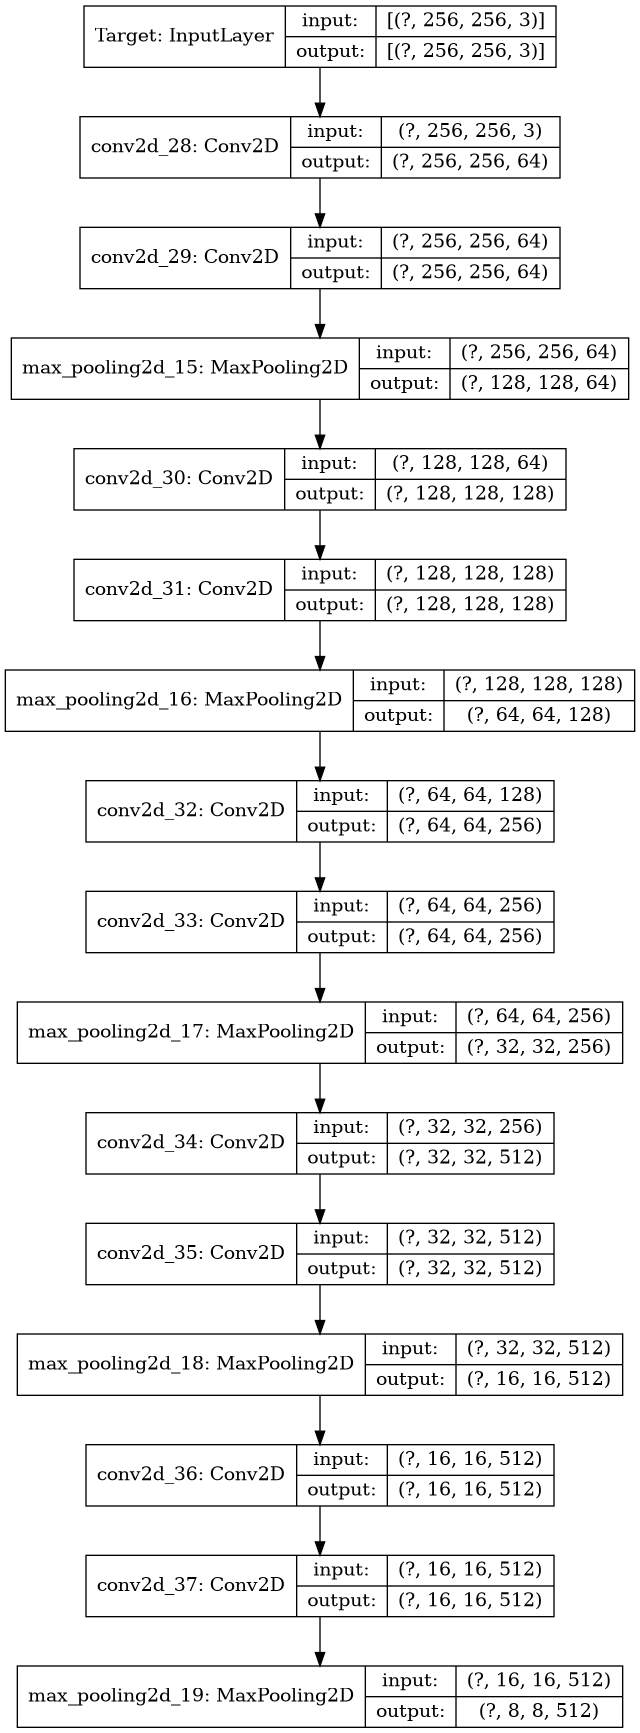

In [19]:
tf.keras.utils.plot_model(modelEncoder, "unet_encoder.png", show_shapes=True)

In [39]:
LInputQuery  = tf.keras.Input(dtype = tf.float32, shape = [64, 64, 3], name = 'Query')
layersConditionalEncoder = [LInputQuery]
with tf.name_scope("Conditional"):
    filtersNumber=[32, 32, None, 64, 64, None, 128, None, 256, None, 512, None]
    for fn in filtersNumber:
        if fn is None:
            layersConditionalEncoder.append(
                tf.keras.layers.MaxPool2D(**maxPoolOptions)(layersConditionalEncoder[-1])
            )
        else:
            layersConditionalEncoder.append(
                tf.keras.layers.Conv2D(filters = fn, **convOptions)(layersConditionalEncoder[-1])
            )
    layersConditionalEncoder.append(
                tf.keras.layers.Conv2D(filters = 512, 
                                       kernel_size = 2, 
                                       strides = 2, 
                                       padding = 'SAME', 
                                       activation = tf.nn.relu
                                      )(layersConditionalEncoder[-1])
            )
#     LCconv1_1 = tf.keras.layers.Conv2D(filters = 32, **convOptions)(LInputQuery) 
#     LCconv1_2 = tf.keras.layers.Conv2D(filters = 32, **convOptions)(LCconv1_1) 
#     LCpool1 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(LCconv1_2)

    
#     LCconv2_1 = tf.keras.layers.Conv2D(filters = 64, **convOptions)(LCpool1) 
#     LCconv2_2 = tf.keras.layers.Conv2D(filters = 64, **convOptions)(LCconv2_1) 
#     LCpool2 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(LCconv2_2)


#     LCconv3_1 = tf.keras.layers.Conv2D(filters = 128, **convOptions)(LCpool2) 
#     LCpool3 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(LCconv3_1)

    
#     LCconv4_1 = tf.keras.layers.Conv2D(filters = 256, **convOptions)(LCpool3) 
#     LCpool4 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(LCconv4_1)

    
#     LCconv5_1 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(LCpool4)  
#     LCpool5 = tf.keras.layers.MaxPool2D((**maxPoolOptions)(LCconv5_1)
    
#     LCconv6_1 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(LCpool5)
#     LCoutput = LCconv6_1
    conditionalEncoderOutput = layersConditionalEncoder[-1]

    modelConditional = tf.keras.Model(
        inputs=LInputQuery,
        outputs=conditionalEncoderOutput, 
        name="Latent Representation Encoder"
    )

In [40]:
modelConditional.summary()

Model: "Latent Representation Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Query (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 1

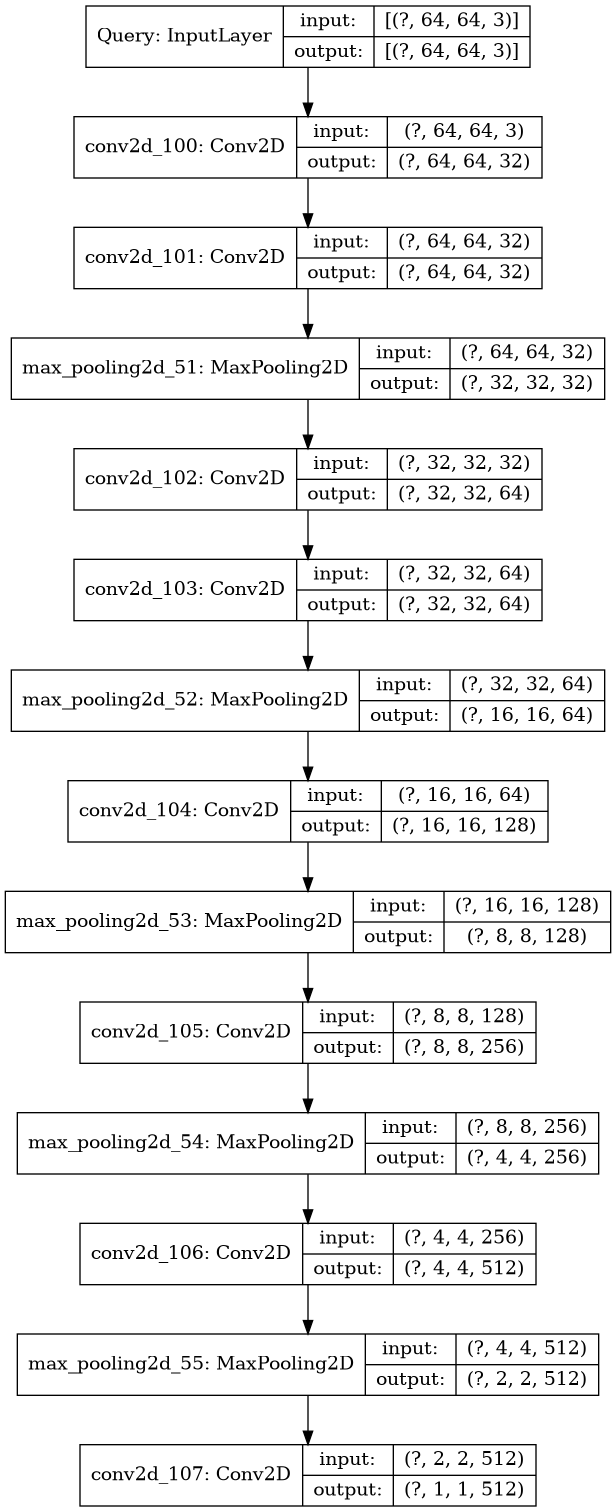

In [41]:
tf.keras.utils.plot_model(modelConditional, "unet_encoder.png", show_shapes=True)

In [42]:
conv1x1Options = {
    "kernel_size": 1,
    "strides": 1,
    "padding": 'SAME', 
    "activation": tf.nn.relu
}
convTransOptions = {
    "kernel_size": 3,
    "strides": (2,2),
    "padding": 'SAME', 
    "activation": tf.nn.relu
}

with tf.name_scope("Transcoder"):
    layersTransDecoder = []
    upsampledLayers = []
    tiles = [(8,8), (16,16), (32, 32), (64, 64), (128,128)]
    filters = [(None, 512, 512, 512), 
               (512, 512, 512, 512), 
               (256, 256, 256, 256), 
               (128, 128, 128, 128),
               (64, 64, 64, 64)]
    
    for tile, encodedInput, fs in zip(tiles, reversed(transcoderInputs), filters):
        # Tiling output from conditional encoder
        layersTransDecoder.append(tf.keras.layers.UpSampling2D(size=tile)(conditionalEncoderOutput))
        # Concatenating tiled output with reverse order of encoder MaxPool layers
        layersTransDecoder.append(tf.keras.layers.Concatenate()([layersTransDecoder[-1], encodedInput]))
        # Flattening the concatenation with 1x1 conv if needed and joining with last cycle's result
        if fs[0] is not None:
            layersTransDecoder.append(tf.keras.layers.Conv2D(fs[0], **conv1x1Options)(layersTransDecoder[-1]))
            layersTransDecoder.append(tf.keras.layers.Concatenate()([layersTransDecoder[-1], upsampledLayers[-1]]))
        # Transdecoding encoded values with Conv2D layers
        layersTransDecoder.append(tf.keras.layers.Conv2D(fs[1], **convOptions)(layersTransDecoder[-1]))
        layersTransDecoder.append(tf.keras.layers.Conv2D(fs[2], **convOptions)(layersTransDecoder[-1]))
        # Upsampling with transposed convolution filters, saving the layer for next cycle merging
        layersTransDecoder.append(tf.keras.layers.Conv2DTranspose(fs[3], **convTransOptions)(layersTransDecoder[-1]))
        upsampledLayers.append(layersTransDecoder[-1])
        
    unetOutput = tf.keras.layers.Conv2D(filters = 1, **convOptions, name="Output")(layersTransDecoder[-1])
    layersTransDecoder.append(unetOutput)
    
#     LDtiling8x8 = tf.keras.layers.UpSampling2D(size=(8, 8))(conditionalEncoderOutput) # [1,1,512] -> [8,8,512]
#     LDconcat1_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool5, LDtiling8x8]) # -> [8,8,1024]
#     LDdeconv1_1 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(LDconcat1_1) # [8,8,1024] -> [8,8,512]
#     LDdeconv1_2 = tf.keras.layers.Conv2D(filters = 512, **convOptions)(LDdeconv1_1)  # [8,8,512]  -> [8,8,512]
#     LDupsam1 = tf.keras.layers.Conv2DTranspose(filters=512, **convTransOptions)(LDdeconv1_2) # [8,8,512] -> [16,16,512]

    
#     LDtiling16x16 = tf.keras.layers.UpSampling2D(size=(16, 16))(LCoutput) # [1,1,512] -> [16,16,512]
#     LDconcat2_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool4, LDtiling16x16]) # -> [16,16,1024]
    
#     LDconv2 = tf.keras.layers.Conv2D(filters = 512, **conv1x1Options)(LDconcat2_1) # [ 16, 16, 1024 ] -> [ 16, 16, 512 ]
#     LDconcat2_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam1, LDconv2]) # -> [ 16, 16, 1024 ]
    
#     LDdeconv2_1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDconcat2_2) # [16,16,1024] -> [16,16,512]
#     LDdeconv2_2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDdeconv2_1)  # [16,16,256]  -> [16,16,512]
#     LDupsam2 = tf.keras.layers.Conv2DTranspose(filters=512, **convTransOptions)(LDdeconv2_2) # [16,16,512] -> [32,32,512]
    
    
#     LDtiling32x32 = tf.keras.layers.UpSampling2D(size=(32, 32))(LCoutput) # [1,1,512] -> [32,32,512]
#     LDconcat3_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool3, LDtiling32x32]) # -> [32,32,1024]
#     LDconv3 = tf.keras.layers.Conv2D(filters = 256, **conv1x1Options)(LDconcat3_1) # -> [32, 32, 256]
    
#     LDconcat3_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam2, LDconv3]) # -> [32,32,768]
#     LDdeconv3_1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDconcat3_2) # [32,32,768] -> [32,32,256]
#     LDdeconv3_2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDdeconv3_1)  # [32,32,256]  -> [32,32,256]
#     LDupsam3 = tf.keras.layers.Conv2DTranspose(filters=256, **convTransOptions)(LDdeconv3_2) # -> [64,64,256]
    
    
#     LDtiling64x64 = tf.keras.layers.UpSampling2D(size=(64, 64))(LCoutput) # [1,1,512] -> [64,64,512]
#     LDconcat4_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool2, LDtiling64x64]) # -> [64,64,768]
#     LDconv4 = tf.keras.layers.Conv2D(filters = 128, **conv1x1Options)(LDconcat4_1) # -> [64, 64, 128]
    
#     LDconcat4_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam3, LDconv4]) # -> [64,64,384]
#     LDdeconv4_1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDconcat4_2) # [64,64,384] -> [64,64,128]
#     LDdeconv4_2 = tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDdeconv4_1)  # [64,64,128]  -> [64,64,128]
#     LDupsam4 = tf.keras.layers.Conv2DTranspose(filters=128, **convTransOptions)(LDdeconv4_2) # -> [128,128,128]
    
    
#     LDtiling128x128 = tf.keras.layers.UpSampling2D(size=(128, 128))(LCoutput) # [1,1,512] -> [128,128,512]
#     LDconcat5_1 = tf.keras.layers.Concatenate(axis=-1)([Lpool1, LDtiling128x128]) # -> [128,128,640]
#     LDconv5 = tf.keras.layers.Conv2D(filters = 64, **conv1x1Options)(LDconcat5_1) # -> [128, 128, 64]
    
#     LDconcat5_2 = tf.keras.layers.Concatenate(axis=-1)([LDupsam4, LDconv5]) # -> [128,128,192]
#     LDdeconv5_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDconcat5_2) # [128,128,192] -> [128,128,64]
#     LDdeconv5_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu)(LDdeconv5_1)  # [128,128,64]  -> [128,128,64]
#     LDupsam5 = tf.keras.layers.Conv2DTranspose(filters=64, **convTransOptions)(LDdeconv5_2) # -> [256,256,64]
#     LDoutput = tf.keras.layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding='SAME', 
#                    activation = tf.nn.relu, name="Output")(LDupsam5)  # [256,256,64]  -> [256,256,1]

    modelUnet = tf.keras.Model(inputs=[LInputTarget, LInputQuery], outputs=[unetOutput], name="Unet")

In [43]:
modelUnet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Target (InputLayer)             [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Query (InputLayer)              [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 64) 1792        Target[0][0]                     
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 64, 64, 32)   896         Query[0][0]                      
_______________________________________________________________________________________________

In [44]:
print(f'{35659553 * (32/8)/1e6}')


142.638212


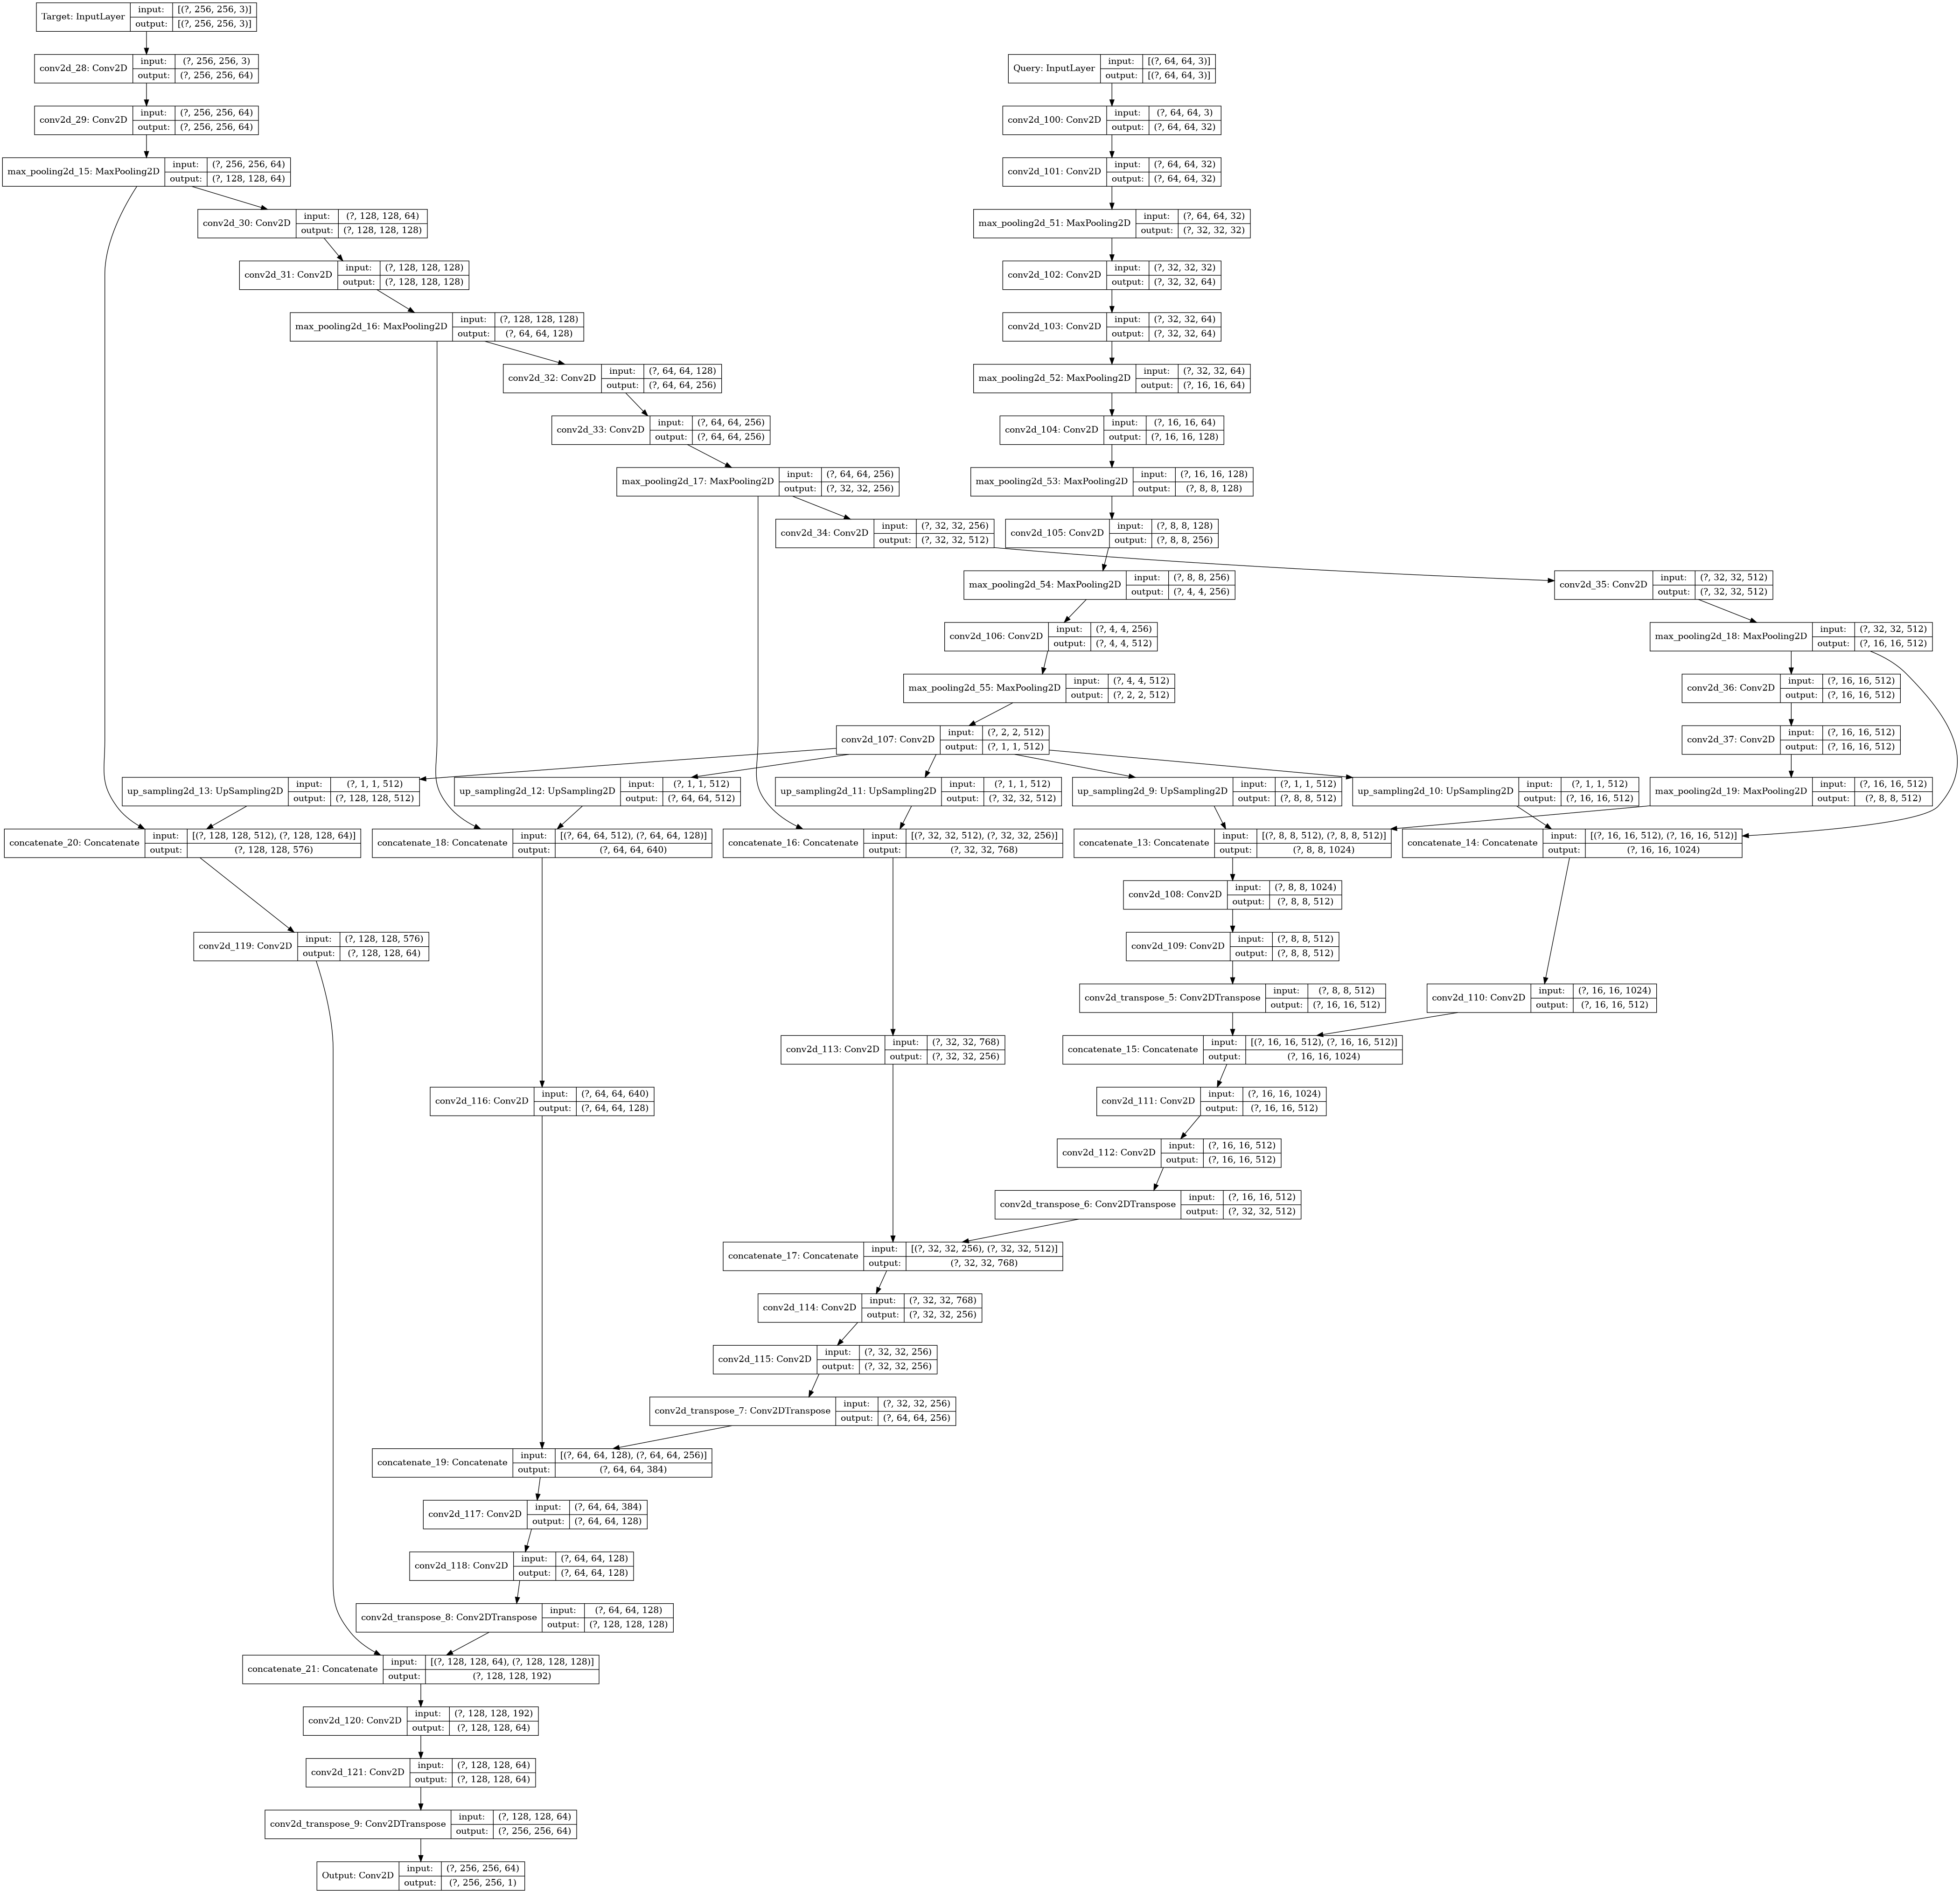

In [45]:
tf.keras.utils.plot_model(modelUnet, "unet_model.png", show_shapes=True)

# Przygotowanie danych

In [46]:
import os
MASKS_PATH = '/qarr/studia/magister/datasets/FlickrLogos-v2/classes/masks/'
INPUT_PATH = '/qarr/studia/magister/datasets/FlickrLogos-v2/classes/jpg/'

classes = [o for o in os.listdir(INPUT_PATH) if os.path.isdir(INPUT_PATH + '/' + o)]
classes = [o for o in classes if o != 'no-logo']


In [47]:
print(classes)

['adidas', 'aldi', 'apple', 'becks', 'bmw', 'carlsberg', 'chimay', 'cocacola', 'corona', 'dhl', 'erdinger', 'esso', 'fedex', 'ferrari', 'ford', 'fosters', 'google', 'guiness', 'heineken', 'hp', 'milka', 'nvidia', 'paulaner', 'pepsi', 'rittersport', 'shell', 'singha', 'starbucks', 'stellaartois', 'texaco', 'tsingtao', 'ups']


## Wczytywanie obrazków do pamięci

In [48]:
images = dict()
targets = dict()
queries = dict()
start_time = time.time()

def rescale(nparray, scale=255.0):
    return np.array(nparray, dtype=np.float32)/scale

for c in classes:
    root_input = INPUT_PATH + '/' + c 
    root_masks = MASKS_PATH + '/' + c
    images[c] = list()
    targets[c] = list()
    queries[c] = list()
    
    for f in os.listdir(root_input):
        img = cv2.imread(f'{root_input}/{f}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(f'{root_masks}/{f}.mask.merged.png', cv2.IMREAD_GRAYSCALE)
        bboxes = []
        
        with open(f'{root_masks}/{f}.bboxes.txt') as csvfile:
            bboxread = csv.reader(csvfile, delimiter=' ')
            next(bboxread)
            for row in bboxread:
                bboxes.append(row)
                
        for bbox in bboxes:
            x,y,w,h = [int(i) for i in bbox]
            imgslice = img[y:y+h, x:x+w]
            imgslice = cv2.resize(imgslice, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
            queries[c].append(rescale(imgslice, 255.0))
            # Biore tylko pierwszy z dostepnych bbox na obrazku
            break 
            
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
        mask = cv2.resize(mask, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
    
        images[c].append(rescale(img, 255.0))
        targets[c].append(rescale(mask, 255.0))


end_time = time.time()

print(f'Time taken: {end_time-start_time} seconds')


Time taken: 19.840173959732056 seconds


## Generowanie listy labeli dla wczytanych obrazków

In [49]:
images_labels = list()
targets_labels = list()
queries_labels = list()

for c in classes:
    images_labels += [classes.index(c)] * len(images[c])
    queries_labels += [classes.index(c)] * len(queries[c])
targets_labels = images_labels

## Wczytane przykłady obrazków

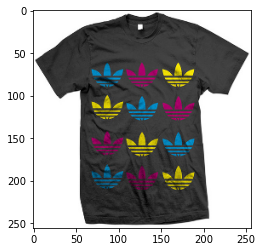

In [50]:
for v in images.values():
    plt.imshow(v[0])
    break

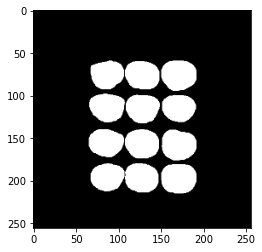

In [51]:
for v in targets.values():
    plt.imshow(v[0], cmap='gist_gray')
    break

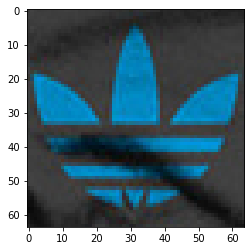

In [52]:
for v in queries.values():
    plt.imshow(v[0])
    break

# Analiza rozmiaru danych

In [53]:
# sumimgs = sum(images.values(), [])
# sumtargs = sum(targets.values(), [])
# sumquers = sum(queries.values(), [])

In [54]:
#images_dataset = tf.data.Dataset.from_tensor_slices((sumimgs, sumtargs, images_labels))

In [55]:
#queries_dataset = tf.data.Dataset.from_tensor_slices((sumquers, queries_labels))

In [56]:
for c in classes:
    print(f'{c:>12}: {len(images[c])} logos: {len(queries[c]):3<} pairs: {len(images[c])*len(queries[c])}')
print(f'{"total":<12}: {sum([len(images[c]) for c in classes])} logos: {sum([len(queries[c]) for c in classes])} pairs: {sum([len(images[c])*len(queries[c]) for c in classes])}')

      adidas: 70 logos: 70 pairs: 4900
        aldi: 70 logos: 70 pairs: 4900
       apple: 70 logos: 70 pairs: 4900
       becks: 70 logos: 70 pairs: 4900
         bmw: 70 logos: 70 pairs: 4900
   carlsberg: 70 logos: 70 pairs: 4900
      chimay: 70 logos: 70 pairs: 4900
    cocacola: 70 logos: 70 pairs: 4900
      corona: 70 logos: 70 pairs: 4900
         dhl: 70 logos: 70 pairs: 4900
    erdinger: 70 logos: 70 pairs: 4900
        esso: 70 logos: 70 pairs: 4900
       fedex: 70 logos: 70 pairs: 4900
     ferrari: 70 logos: 70 pairs: 4900
        ford: 70 logos: 70 pairs: 4900
     fosters: 70 logos: 70 pairs: 4900
      google: 70 logos: 70 pairs: 4900
     guiness: 70 logos: 70 pairs: 4900
    heineken: 70 logos: 70 pairs: 4900
          hp: 70 logos: 70 pairs: 4900
       milka: 70 logos: 70 pairs: 4900
      nvidia: 70 logos: 70 pairs: 4900
    paulaner: 70 logos: 70 pairs: 4900
       pepsi: 70 logos: 70 pairs: 4900
 rittersport: 70 logos: 70 pairs: 4900
       shell: 70 logos: 7

In [57]:
print(f"{32*(70*69)*(64*64*3+256*256*4)*8/1e9} GB vs {32*(70)*(64*64*3+256*256*4)*8/1e9} GB")

339.32967936 GB vs 4.91782144 GB


Gdyby brać pod uwagę każde logo z obrazka:
```
      adidas: 70 logos: 120 pairs: 8400
        aldi: 70 logos: 106 pairs: 7420
       apple: 70 logos: 76 pairs: 5320
       becks: 70 logos: 100 pairs: 7000
         bmw: 70 logos: 74 pairs: 5180
   carlsberg: 70 logos: 108 pairs: 7560
      chimay: 70 logos: 112 pairs: 7840
    cocacola: 70 logos: 130 pairs: 9100
      corona: 70 logos: 83 pairs: 5810
         dhl: 70 logos: 123 pairs: 8610
    erdinger: 70 logos: 105 pairs: 7350
        esso: 70 logos: 87 pairs: 6090
       fedex: 70 logos: 94 pairs: 6580
     ferrari: 70 logos: 73 pairs: 5110
        ford: 70 logos: 76 pairs: 5320
     fosters: 70 logos: 98 pairs: 6860
      google: 70 logos: 83 pairs: 5810
     guiness: 70 logos: 98 pairs: 6860
    heineken: 70 logos: 103 pairs: 7210
          hp: 70 logos: 112 pairs: 7840
       milka: 70 logos: 197 pairs: 13790
      nvidia: 70 logos: 114 pairs: 7980
    paulaner: 70 logos: 102 pairs: 7140
       pepsi: 70 logos: 178 pairs: 12460
 rittersport: 70 logos: 204 pairs: 14280
       shell: 70 logos: 96 pairs: 6720
      singha: 70 logos: 83 pairs: 5810
   starbucks: 70 logos: 95 pairs: 6650
stellaartois: 70 logos: 87 pairs: 6090
      texaco: 70 logos: 88 pairs: 6160
    tsingtao: 70 logos: 109 pairs: 7630
         ups: 70 logos: 90 pairs: 6300
total       : 2240 logos: 3404 pairs: 238280
```

# Generator danych

In [58]:
def dataset_permutations_generator(batch_size):
    nclasses = len(classes)
    nlogos = sum([len(images[c]) for c in classes])//nclasses
    data_permutations = np.zeros((nclasses*nlogos*(nlogos-1), 3), dtype=np.int8)
    i = 0
    for c_i in range(nclasses):
        for n_i in range(nlogos):
            for l_i in range(nlogos):
                if n_i == l_i:
                    continue
                data_permutations[i] = (c_i, n_i, l_i)
                i += 1
    data_permutations = np.random.permutation(data_permutations)
    s = 0
    outimage = []
    outquery = []
    outtarget = []
    for class_number, image_number, query_number in data_permutations:
        c = classes[class_number]
        outimage.append(images[c][image_number])
        outquery.append(queries[c][query_number])
        outtarget.append(targets[c][image_number])
        s += 1
        if s >= batch_size:
            s = 0
            yield (np.reshape(outimage, (batch_size, 256, 256, 3)),
                   np.reshape(outquery, (batch_size, 64, 64, 3))
                  ), np.reshape(outtarget, (batch_size, 256, 256, 1))
            outimage = []
            outquery = []
            outtarget = []

## Test generatora

In [59]:
testgen = dataset_permutations_generator(1)
tdat = next(testgen)

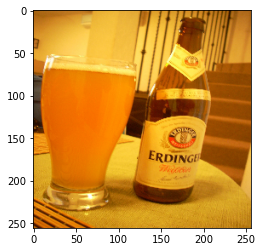

In [60]:
plt.imshow(tdat[0][0][0])

In [61]:
batch_size = 1
unetDataset = tf.data.Dataset.from_generator(dataset_permutations_generator,
                                             args=[batch_size],
                                             output_types=((tf.float32, tf.float32), tf.float32),
                                             output_shapes=(((batch_size, 256,256,3), (batch_size, 64,64,3)),
                                                          (batch_size, 256,256,1))
                                            )
#unetDataset = unetDataset.cache()

# Zestawienie modelu i uczenie - próba

In [62]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0004, momentum=0.9, nesterov=False, name="SGD") # weight decay 0.0005

modelUnet.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.BinaryCrossentropy(
                        name="binary_crossentropy")]
                 )

### Próbkowanie generatora - test na minibatchu

In [63]:
gen_inst = dataset_permutations_generator(batch_size)
custom_batch = [next(gen_inst) for i in range(1)]

In [64]:
def describe(x):
    try:
        return f'{x.shape}'
    except AttributeError:
        return f"{'[' + ', '.join([describe(q) for q in x]) + ']'}"


#custom_batch[0]
print(describe(custom_batch[0]))

[[(1, 256, 256, 3), (1, 64, 64, 3)], (1, 256, 256, 1)]


In [65]:
testDataset = tf.data.Dataset.from_tensors(custom_batch[0])
#testDataset = testDataset.batch(32)

In [66]:
modelUnet.fit(testDataset, epochs=1, steps_per_epoch=1, batch_size=batch_size)

1/1 [==============================] - 0s 3ms/step - loss: 2.4393e-09 - binary_crossentropy: 0.3142


# Próba generalna

In [67]:
batch_size = 24
unetDataset = tf.data.Dataset.from_generator(dataset_permutations_generator,
                                             args=[batch_size],
                                             output_types=((tf.float32, tf.float32), tf.float32),
                                             output_shapes=(((batch_size, 256,256,3), (batch_size, 64,64,3)),
                                                          (batch_size, 256,256,1))
                                            )

In [68]:
# Create a TensorBoard callback
from datetime import datetime
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

try:
    tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '1,10')
except AlreadyExistsError:
    pass

In [69]:
nsamples = 154560
modelUnet.fit(unetDataset, epochs=10, steps_per_epoch=5, batch_size=batch_size)#, callbacks=[tboard_callback])

Epoch 1/10
5/5 [==============================] - 4s 723ms/step - loss: 1.2941e-08 - binary_crossentropy: 1.6691
Epoch 2/10
5/5 [==============================] - 3s 700ms/step - loss: 1.3101e-08 - binary_crossentropy: 1.6905
Epoch 3/10
5/5 [==============================] - 3s 699ms/step - loss: 1.3376e-08 - binary_crossentropy: 1.7252
Epoch 4/10
5/5 [==============================] - 3s 700ms/step - loss: 1.0922e-08 - binary_crossentropy: 1.4079
Epoch 5/10
5/5 [==============================] - 3s 696ms/step - loss: 1.5366e-08 - binary_crossentropy: 1.9836
Epoch 6/10
5/5 [==============================] - 4s 716ms/step - loss: 1.2606e-08 - binary_crossentropy: 1.6265
Epoch 7/10
5/5 [==============================] - 4s 701ms/step - loss: 1.2888e-08 - binary_crossentropy: 1.6620
Epoch 8/10
5/5 [==============================] - 4s 704ms/step - loss: 1.3274e-08 - binary_crossentropy: 1.7125
Epoch 9/10
5/5 [==============================] - 4s 702ms/step - loss: 1.5364e-08 - binary_cros